## **미니 프로젝트 : 가위바위보 분류기를 만들자**

### **데이터를 준비하자**

#### **데이터 불러오기 + Resize 하기**

In [1]:
from PIL import Image
import glob
import os

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
def resize_images(imgFolder_path):
    images=glob.glob(imgFolder_path + "/*.png")
    
    print(len(images), " images to be resized.")
    
    # 파일마다 모두 150x150 사이즈로 바꾸어 저장한다.
    target_size=(150, 150)
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
    
        # 이미지가 RGBA 형식인 경우, RGB로 변환한다.
        if new_img.mode == "RGBA":
            new_img = new_img.convert("RGB")
        
        # 이미지를 저장한다.
        new_img.save(img, "PNG")
    
    print(len(images), " images resized.")

In [3]:
# 학습 이미지 resize
image_dir_path = os.getenv("HOME") + "/aiffel/rock_paper_scissors/train/scissors"
resize_images(image_dir_path)

image_dir_path = os.getenv("HOME") + "/aiffel/rock_paper_scissors/train/rock"
resize_images(image_dir_path)

image_dir_path = os.getenv("HOME") + "/aiffel/rock_paper_scissors/train/paper"
resize_images(image_dir_path)

print("가위바위보 이미지 모두 resize 완료!")

840  images to be resized.
840  images resized.
840  images to be resized.
840  images resized.
840  images to be resized.
840  images resized.
가위바위보 이미지 모두 resize 완료!


In [4]:
def load_data(img_path, number_of_data=2520): # 가위바위보 이미지 개수 총합
    # 가위: 0, 바위: 1, 보: 2
    img_size=150
    color=3
    # 이미지 데이터와 라벨(가위: 0, 바위: 1, 보: 2) 데이터를 담을 행렬(matrix) 영역을 생성한다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissors/*.png'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0 # 가위: 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.png'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1 # 바위: 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.png'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2 # 보: 2
        idx=idx+1
        
    print("데이터의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_paper_scissors/train"
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0 # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

데이터의 이미지 개수는 2520 입니다.
x_train shape: (2520, 150, 150, 3)
y_train shape: (2520,)


In [5]:
# 데이터 shuffle
np.random.seed(24)
shuffle_indexes = np.random.permutation(len(x_train_norm))
x_train_shuffle = x_train_norm[shuffle_indexes]
y_train_shuffle = y_train[shuffle_indexes]

print("데이터 섞기 완료!")

데이터 섞기 완료!


라벨:  0


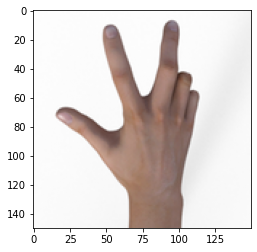

In [6]:
# 학습 이미지 확인
plt.imshow(x_train_shuffle[0])
print('라벨: ', y_train_shuffle[0])

라벨:  1


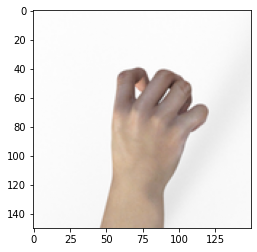

In [7]:
plt.imshow(x_train_shuffle[840])
print('라벨: ', y_train_shuffle[840])

### **딥러닝 네트워크 설계하기**

In [8]:
# 모델 생성
model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3), kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       7

### **딥러닝 네트워크 학습시키기**

In [9]:
# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 모델 학습
early_stopping_cb = EarlyStopping(patience=6,
                                  monitor='val_loss',
                                  restore_best_weights=True)
history = model.fit(x_train_shuffle, y_train_shuffle,
                    epochs=10,
                    validation_split=0.3,
                    callbacks=[early_stopping_cb])

Epoch 1/10
56/56 [==============================] - 6s 43ms/step - loss: 1.9585 - accuracy: 0.5930 - val_loss: 1.5243 - val_accuracy: 0.7765
Epoch 2/10
56/56 [==============================] - 1s 24ms/step - loss: 1.2919 - accuracy: 0.8452 - val_loss: 1.0251 - val_accuracy: 0.9630
Epoch 3/10
56/56 [==============================] - 1s 25ms/step - loss: 0.9543 - accuracy: 0.9688 - val_loss: 0.8331 - val_accuracy: 0.9907
Epoch 4/10
56/56 [==============================] - 1s 25ms/step - loss: 0.8076 - accuracy: 0.9921 - val_loss: 0.7704 - val_accuracy: 0.9947
Epoch 5/10
56/56 [==============================] - 1s 24ms/step - loss: 0.7466 - accuracy: 0.9938 - val_loss: 0.7114 - val_accuracy: 0.9974
Epoch 6/10
56/56 [==============================] - 1s 25ms/step - loss: 0.6991 - accuracy: 0.9955 - val_loss: 0.6706 - val_accuracy: 0.9974
Epoch 7/10
56/56 [==============================] - 1s 25ms/step - loss: 0.6576 - accuracy: 0.9972 - val_loss: 0.6374 - val_accuracy: 0.9974
Epoch 8/10
56

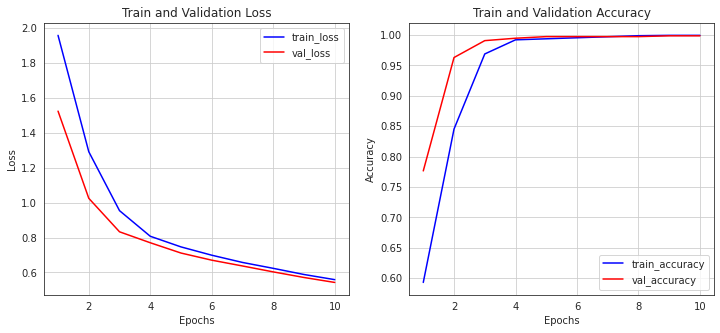

In [10]:
# 시각화
sns.set_style('white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

### **얼마나 잘 만들었는지 확인하기(테스트)**

In [11]:
# 테스트 이미지 resize
image_dir_path = os.getenv("HOME") + "/aiffel/rock_paper_scissors/test/scissors"
resize_images(image_dir_path)

image_dir_path = os.getenv("HOME") + "/aiffel/rock_paper_scissors/test/rock"
resize_images(image_dir_path)

image_dir_path = os.getenv("HOME") + "/aiffel/rock_paper_scissors/test/paper"
resize_images(image_dir_path)

print("테스트 이미지 resize 완료!")

124  images to be resized.
124  images resized.
124  images to be resized.
124  images resized.
124  images to be resized.
124  images resized.
테스트 이미지 resize 완료!


In [12]:
# x_test, y_test 만들기
image_dir_path = os.getenv("HOME") + "/aiffel/rock_paper_scissors/test"
(x_test, y_test)=load_data(image_dir_path, 372)
x_test_norm = x_test/255.0 

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

데이터의 이미지 개수는 372 입니다.
x_test shape: (372, 150, 150, 3)
y_test shape: (372,)


라벨:  0


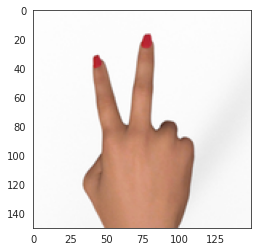

In [13]:
# 테스트 이미지 확인
plt.imshow(x_test[0])
print('라벨: ', y_test[0])

In [14]:
# 모델 평가
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

12/12 - 0s - loss: 0.7067 - accuracy: 0.9409
test_loss: 0.7067398428916931
test_accuracy: 0.9408602118492126


---

### **프로젝트 회고**

이번 프로젝트가 아마 지금까지 한 프로젝트 중에서 가장 많은 시간을 투자하고 개인적으로 가장 어렵게 느껴졌던 프로젝트가 아닐까 싶다. 처음에는 하이퍼파라미터 변경 정도만 해도 정확도를 많이 높일 수 있을 거라고 생각했고 MNIST를 이용한 숫자 분류 코드를 참고해서 조금만 수정하면 그다지 어렵지 않은 과제일 거라고 생각했었다. 처음에 노드에서 알려준대로만 진행했을 때 정확도는 고작 20% 정도 밖에 되지 않았고 그 이후에 아무리 시도해도 30-40%를 벗어나지 못 해 엄청나게 애를 먹었다. 여러가지 시도 끝에 어느 순간 프로젝트에서 요구하는 60%는 넘겼지만 더 높은 점수를 달성해보고 싶은 욕심에 더 붙들고 있었고, 최종적으로 약 94%의 정확도로 마무리 할 수 있었다. 학습과 검증 데이터의 정확도는 높은데 테스트 데이터를 사용해 채점을 할 경우 정확도가 너무 낮아 도대체 왜 그런 건지 알 수가 없어 답답했던 순간도 있었던 것 같고, 생각보다 점수가 너무 오르지 않아 스트레스를 받은 순간도 있었지만, 내 끈기를 다시 한 번 확인할 수 있는 좋은 경험이였던 것 같다.   

**Overfitting을 극복하기 위해 내가 시도해본 것**
1. 데이터셋 변경: Kaggle의 Rock Paper Scissors 데이터셋 사용
2. 데이터 분할: 훈련 데이터와 검증 데이터를 7:3 비율로 배분
3. Shuffle: 데이터의 순서를 섞어서 모델이 다양한 패턴을 학습하도록 함
4. L2 Regularization: 가중치에 L2 정규화 항 추가하여 모델 복잡성 제어
5. Dropout: 일부 뉴런을 임의로 비활성화하여 모델의 일반화 능력 향상
6. Early Stopping: 검증 손실이 더 이상 개선되지 않을 때 훈련 중단하여 overfitting 방지
7. 하이퍼파라미터 튜닝: 모델의 성능을 최적화하기 위해 하이퍼파라미터 조정
8. 이미지 크기 조절: 작은 이미지 크기로 조정하여 일반화 능력 향상 및 계산 효율성 개선

**추가로 시도해보면 좋을 것**
1. Data Augmentation: 이미지 데이터를 변형하여 데이터 다양성 증가
2. 더 많은 데이터 수집: 추가 데이터 수집으로 모델의 다양성과 일반화 능력 향상
3. Pre-trained 모델 활용: 사전 학습된 모델을 사용하여 모델 구축
4. Cross-validation: 데이터를 여러 부분으로 나누어 모델의 일반화 능력 평가

#### **새로 알게 된 것!**
좋은 데이터는 좋은 모델을 구축하는 데 매우 중요한 역할을 한다.  
따라서, 데이터의 품질과 다양성은 모델의 성능에 큰 영향을 미치며, 데이터 수집과 전처리에 충분한 주의를 기울이는 것이 중요하다!

**참고한 레퍼런스**
<br>Rock Paper Scissors Dataset https://www.kaggle.com/datasets/sanikamal/rock-paper-scissors-dataset
<br>과적합 방지와 CNN https://kau-deeperent.tistory.com/101
<br>07-06 과적합(Overfitting)을 막는 방법들 https://wikidocs.net/61374
<br>[딥러닝] 가위 바위 보 판별 Accuracy 높이는 방법 탐구 https://proveyourdream.tistory.com/79
<br>[SSAC×AIFFEL] 20210105 가위바위보 분류기 만들기 https://velog.io/@shoulmon/20210105-%EA%B0%80%EC%9C%84%EB%B0%94%EC%9C%84%EB%B3%B4-%EB%B6%84%EB%A5%98%EA%B8%B0-%EB%A7%8C%EB%93%A4%EA%B8%B0